## This is the final deep learning project
## This is an application of facial recognition using a siamese deep neural network

1. Problem statement (0-10)
	* How well is the problem defined?
	* Does the research address a real-life problem?
	* Does the research solve the correct problem?
2. Layout (0-20)
	* Are the document sections structured properly?
	* Is the article well-formatted (in terms of readability)?
3. Code quality (0-20)
	* Is the code well-written? Is the code self-documenting?
	* Is the code organized into functions?
	* Is the code generally well-structured?
4. Previous research (0-10)
	* Have you cited at least two other sources?
	* Does the project contain comparisons between the current and the previous results?
5. Gathering / generating, cleaning, and formatting data (0-10)
	* Every problem deals with "real-world" data in some way. Even if you don't use datasets, you'll likely generate some data
	* How is the data gathered?
	* Is the process statistically valid?
	* Is the process of data acquisition, data cleaning, and data manipulation well documented?
6. Testing (0-10)
	* This can have various meanings: unit testing, hypothesis testing, train / test data set, etc.
	* Is the code thoroughly tested?
	* Are there any comparisons to other implementations / other articles / previous research?
7. Visualization (0-10)
	* All kinds of projects employ some visualization: graphical plots, tables, etc.
	* Are all visualizations correct (i.e. convey the intended meaning without misleading the intended audience)?
	* Are all visualizations clear, and easy to understand?
8. Communication (0-10)
	* Does the project tell the story correctly?
	* Does the project serve the audience it was intended for?

# Load libraries

In [ ]:
# %pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [1]:
import cv2
import os
import random  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# I will use the functional api for this project


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

import tensorflow as tf


Create folder structure

In [3]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
# I will use the lfw images as my negatives images 
# Source link: http://vis-www.cs.umass.edu/lfw/ 

#  Transfer the data from the lfw folder to the data/negatives
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

Collect positive and anchor images

what is anchor\
what are positives

In [5]:
# Library for generating unique image names

import uuid

In [6]:
uuid.uuid1()

UUID('a19352c9-8c3e-11ed-a5d6-acfdceba6016')

In [7]:
# CONNECTION TO MY CAMERA
# and gathering of the data

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # make the frame 250/250 pixels
    frame = frame[120:120 + 250,200:200+250,:]

    # colect the anchor images
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # create an unique name
        image_name = os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(image_name,frame)

    # collect the positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # create an unique name
        image_name = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(image_name,frame)

    # Show the image to the screen
    cv2.imshow('Image Collection', frame)

    # wait 1 ms and close if the button 'q' is clicked
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# release the camera
cap.release()
# close the image show frame
cv2.destroyAllWindows()

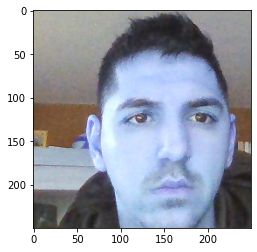

In [9]:
plt.imshow(frame)